In [272]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
import pennylane as qml
from pennylane import numpy as np
from functools import reduce
import cirq
from tensorflow import keras
from eqmarl import *
import tensorflow as tf

In [274]:
# Check shapes of variational+encoding PQC parameters.
wires = list(range(4))
shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
shape_var, shape_enc

((2, 4, 3), (1, 4, 1))

In [275]:
def TensorPauliZ(wires, n, d) -> list:
    all_obs = []
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
        obs = reduce((lambda a, b: a @ b), ops)
        all_obs.append(obs)
        all_obs.append(-obs)
    return all_obs


def IndividualPauliZ(wires) -> list:
    all_obs = []
    for w in wires:
        obs = qml.PauliZ(w)
        all_obs.append(obs)
    return all_obs

In [276]:
class AgentCircuit:
    
    def __init__(self,
        wires,
        n_layers,
        obs_func = None,
        initial_state_vector: str|np.ndarray = None,
        ):
        self.wires = wires
        self.d_qubits = len(wires)
        self.n_layers = n_layers
        
        if obs_func is None:
            obs_func = lambda wires: TensorPauliZ(wires, 1, self.d_qubits)
        self.obs_func = obs_func
        self.initial_state_vector = initial_state_vector

    def __call__(self, weights_var, weights_enc, inputs=None):

        # Prepare initial state via state vector.
        if self.initial_state_vector is not None:
            qml.QubitStateVector(self.initial_state_vector, wires=self.wires)
        
        # Encoding parameters.
        # If inputs were provided then do the following:
        # - Treat `enc_inputs` as lambda values which are multiplied by `inputs`.
        # - `agents_enc_inputs` will NOT have a batch dimension
        # - `inputs` will be 2D with shape (batch, n_agents * d_qubits).
        if inputs is not None:
            inputs = np.reshape(inputs, (-1, self.d_qubits)) # Ensure shape is 2D with (batch, d_qubits)
            print(f"BEFORE: {inputs.shape=}")
            print(f"BEFORE: {weights_enc.shape=}")
            weights_enc = np.einsum("lqf,bq->blqf", weights_enc, inputs) # For each agent, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
            print(f"AFTER: {weights_enc.shape=}")
        
        VariationalEncodingPQC(
            weights_var=weights_var,
            weights_enc=weights_enc,
            n_layers=self.n_layers,
            wires=self.wires,
            )

        # measurements = [qml.expval(qml.PauliZ(wires=w)) for w in self.wires]
        # return measurements
        
        # Build dynamic list of measurements.
        measurements = []
        obs = self.obs_func(self.wires)
        for o in obs:
            measurements.append(qml.expval(o))

        return measurements
    
    @property
    def shape(self):
        return self.get_shape(self.wires, self.n_layers)
    
    @property
    def output_shape(self):
        """Returns number of observables at output.
        
        This is useful in combination with `qml.KerasLayer`.
        """
        return (len(self.obs_func(self.wires)),)

    @property
    def input_shape(self):
        """Returns required shape for `inputs` argument.
        
        Note 1: The returned shape does not include the batch dimension.
        Note 2: PennyLane will compress inputs to 2D when batching for usage with `KerasLayer` or `TorchLayer`.
        """
        return (self.d_qubits,)

    @staticmethod
    def get_shape(wires, n_layers):
        return VariationalEncodingPQC.shape(
            n_layers=n_layers,
            wires=wires,
            )


wires = list(range(4))

batch_size = 16
n_layers = 3
circuit = AgentCircuit(wires=wires, n_layers=n_layers)

dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

# Assign random circuit parameters.
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

res = qnode(weights_var, weights_enc) # Shape is (n_observables, batch)
res = np.asarray(res).T # Reshape to (batch, n_observables)

(<Figure size 3000x500 with 1 Axes>, <Axes: >)

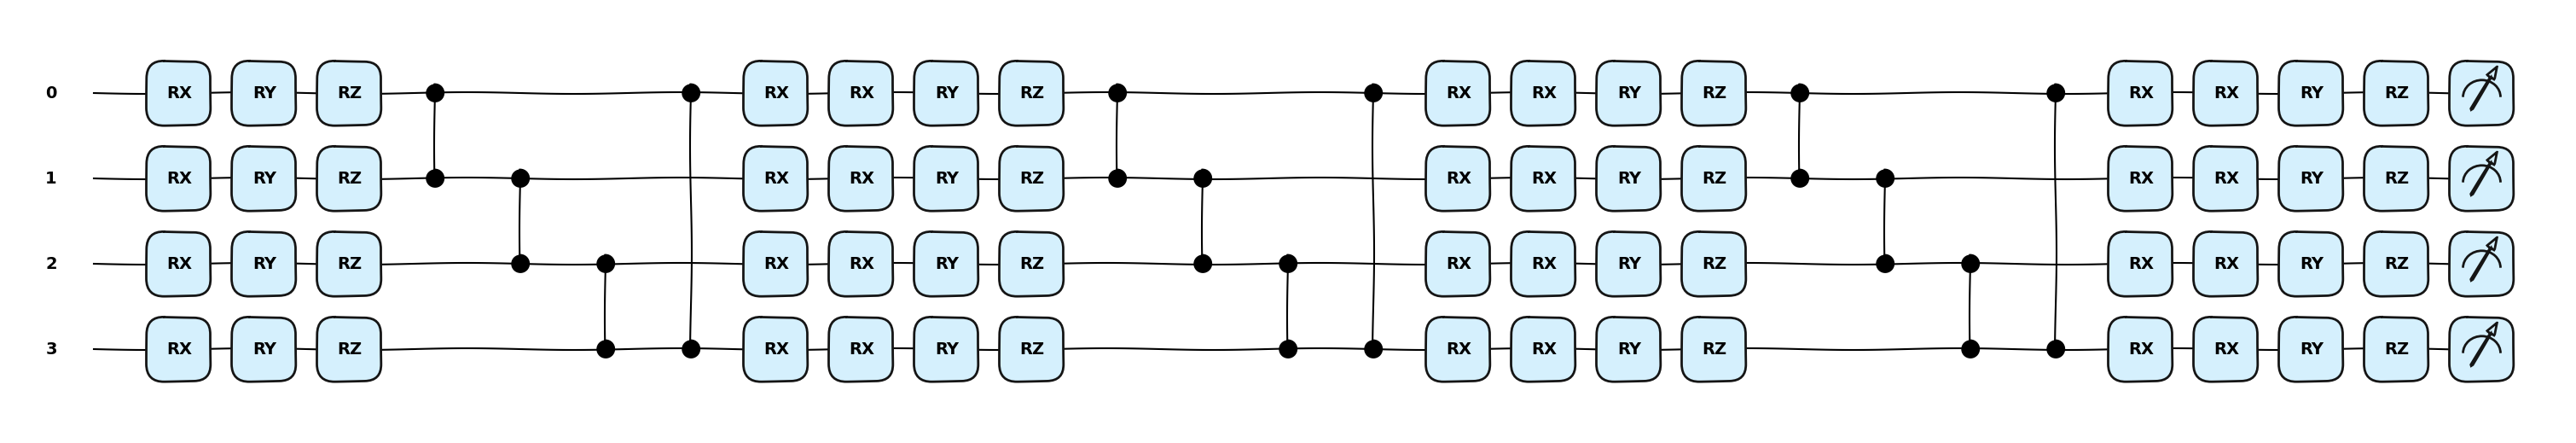

In [277]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [278]:
shape_var, shape_enc = circuit.shape
wires = circuit.wires

weight_shapes = {
    'weights_var': shape_var,
    'weights_enc': shape_enc,
}
qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=circuit.output_shape)
qlayer

# inp = keras.Input(shape=circuit.input_shape)
inp = keras.Input(shape=circuit.input_shape)
model = keras.Sequential([
    inp,
    qlayer,
    keras.layers.Softmax(),
    ])
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_39 (KerasLayer  (None, 2)                 60        
 )                                                               
                                                                 
 softmax_23 (Softmax)        (None, 2)                 0         
                                                                 
Total params: 60 (240.00 Byte)
Trainable params: 60 (240.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
inputs = np.random.uniform(low=0., high=np.pi, size=(16, *circuit.input_shape))
# inputs = np.random.uniform(low=0., high=np.pi, size=circuit.input_shape)
res = model(inputs)

inputs.shape, res.shape

BEFORE: inputs.shape=(16, 4)
BEFORE: weights_enc.shape=TensorShape([3, 4, 1])
AFTER: weights_enc.shape=(16, 3, 4, 1)


((16, 4), TensorShape([16, 2]))

In [280]:
class MARLCircuit:
    
    def __init__(self,
        n,
        d,
        n_layers,
        obs_func = None,
        initial_state_vector: str|np.ndarray = None,
        ):
        self.n_agents = n
        self.d_qubits = d
        self.wires = list(range(n * d))
        self.n_layers = n_layers
        
        if obs_func is None:
            obs_func = lambda wires: TensorPauliZ(wires, self.n_agents, self.d_qubits)
        self.obs_func = obs_func
        self.initial_state_vector = initial_state_vector

    def __call__(self, 
        agents_var_thetas: np.ndarray,
        agents_enc_inputs: np.ndarray,
        inputs = None, # Required for keras layer support; must have shape (batch, n_agents, d_qubits).
        ):

        # Prepare initial state using pre-determined state-prep function.
        if isinstance(self.initial_state_vector, str):
            match self.initial_state_vector:
                case 'phi+':
                    entangle_agents_phi_plus(self.wires, self.d_qubits, self.n_agents)
                case 'phi-':
                    entangle_agents_phi_minus(self.wires, self.d_qubits, self.n_agents)
                case 'psi+':
                    entangle_agents_psi_plus(self.wires, self.d_qubits, self.n_agents)
                case 'psi-':
                    entangle_agents_psi_minus(self.wires, self.d_qubits, self.n_agents)
        # OR, prepare initial state via state vector.
        elif self.initial_state_vector is not None:
            qml.QubitStateVector(self.initial_state_vector, wires=self.wires)

        # Create sub-circuit for each agent.
        for aidx in range(self.n_agents):
            qidx = aidx * self.d_qubits # Starting qubit index for the specified agent.
            
            # Variational parameters (batching is optional).
            weights_var = agents_var_thetas[..., aidx, :, :, :]
            
            # Encoding parameters.
            # If inputs were provided then do the following:
            # - Treat `enc_inputs` as lambda values which are multiplied by `inputs`.
            # - `agents_enc_inputs` will NOT have a batch dimension
            # - `inputs` will be 2D with shape (batch, n_agents * d_qubits).
            if inputs is not None:
                inputs = np.reshape(inputs, (-1, self.n_agents, self.d_qubits)) # Ensure shape is 3D with (batch, n_agents, d_qubits)
                weights_enc = np.einsum("alqf,baq->baqf", agents_enc_inputs, inputs) # For each agent, encode each `input` state feature `q` on the `q-th` qubit and repeat encoding on same qubit for every layer `l`. Number of input features must match number of qubits.
            else:
                weights_enc = agents_enc_inputs[..., aidx, :, :, :]
            
            # Add PQC for the wires corresponding to the current agent.
            VariationalEncodingPQC(
                weights_var=weights_var,
                weights_enc=weights_enc,
                n_layers=self.n_layers,
                wires=self.wires[qidx:qidx + self.d_qubits],
            )

        # Build dynamic list of measurements.
        measurements = []
        obs = self.obs_func(self.wires)
        for o in obs:
            measurements.append(qml.expval(o))

        return measurements
    
    @property
    def shape(self):
        return self.get_shape(self.n_agents, self.d_qubits, self.n_layers)
    
    @property
    def output_shape(self):
        """Returns number of observables at output.
        
        This is useful in combination with `qml.KerasLayer`.
        """
        return (len(self.obs_func(self.wires)),)

    @property
    def input_shape(self):
        """Returns required shape for `inputs` argument.
        
        Note 1: The returned shape does not include the batch dimension.
        Note 2: PennyLane will compress inputs to 2D when batching for usage with `KerasLayer` or `TorchLayer`.
        """
        return (self.n_agents * self.d_qubits,)

    @staticmethod
    def get_shape(n, d, n_layers):
        wires = list(range(n * d))
        shape_var, shape_enc = VariationalEncodingPQC.shape(
            n_layers=n_layers,
            wires=wires[:d], # All agents are identical, so only need shape of first agent (wires 0, 1, ..., d-1).
            )
        shape_var = (n, *shape_var,)
        shape_enc = (n, *shape_enc,)
        return shape_var, shape_enc


n_layers = 3
n_agents = 3
d_qubits = 3
circuit = MARLCircuit(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=None,
    )
wires = circuit.wires

dev = qml.device('default.qubit', wires=wires)
qnode = qml.QNode(func=circuit, device=dev)

# Assign random circuit parameters.
batch_size = 16
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

# Evaluate circuit.
res = qnode(weights_var, weights_enc) # Shape is (n_agents * n_observables, batch)
res = np.asarray(res)
# res = np.asarray(res).T.reshape((-1, n_agents, 2)) # Reshape to (batch, n_agents, n_observables)
res.shape

(6, 16)

(<Figure size 2700x1000 with 1 Axes>, <Axes: >)

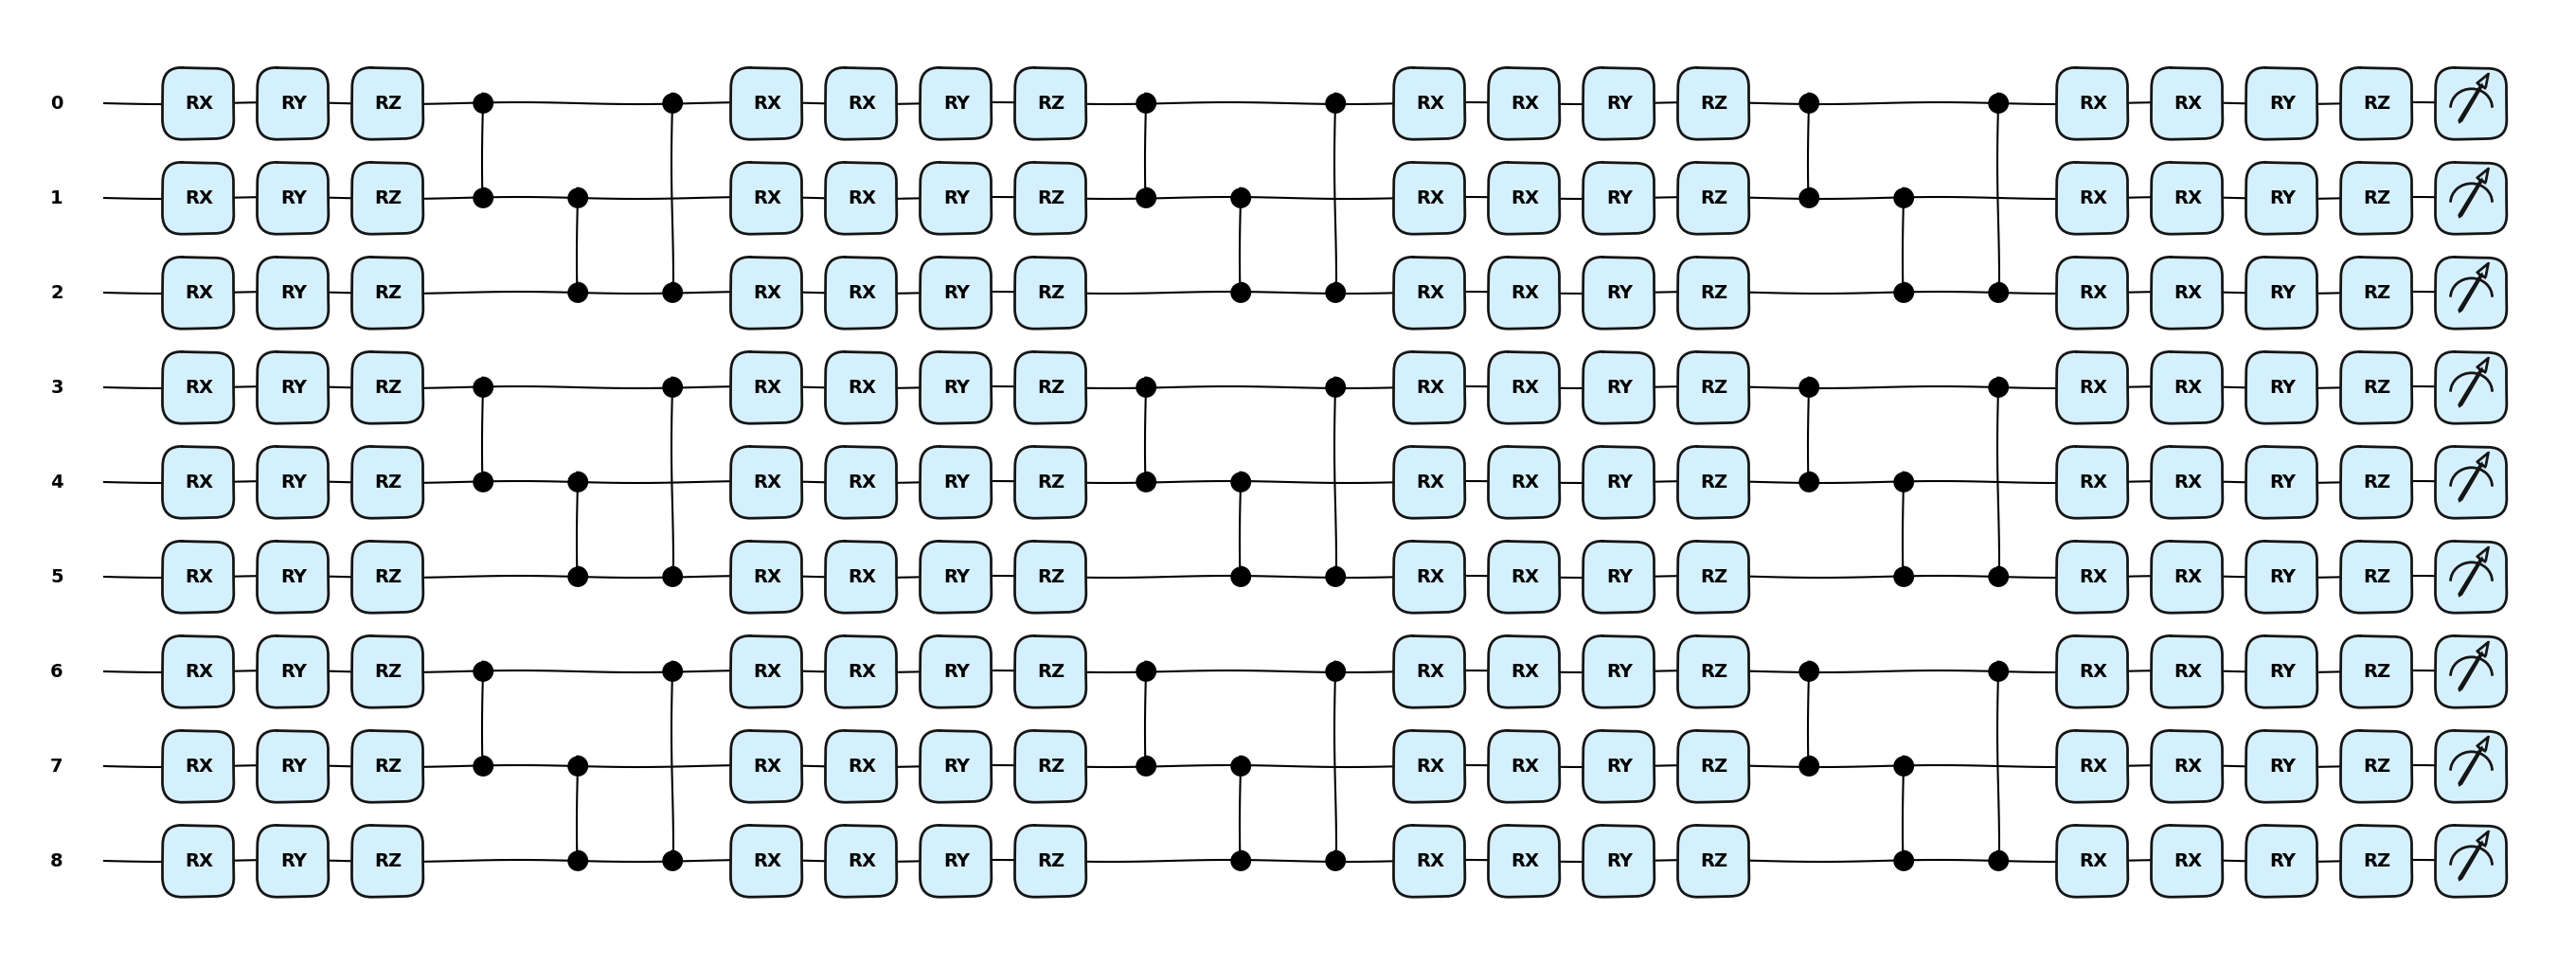

In [281]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [282]:
def softmax(x, axis=None):
    x = x - np.max(x, axis=axis, keepdims=True)
    y = np.exp(x)
    return y / np.sum(y, axis=axis, keepdims=True)

In [283]:
shape_var, shape_enc = circuit.shape
wires = circuit.wires

weight_shapes = {
    'agents_var_thetas': shape_var,
    'agents_enc_inputs': shape_enc,
}
qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=circuit.output_shape)
qlayer

# inp = keras.Input(shape=circuit.input_shape)
inp = keras.Input(shape=circuit.input_shape)
model = keras.Sequential([
    inp,
    qlayer,
    keras.layers.Reshape(target_shape=(n_agents, 2)), # Using `TensorPauliZ` as observables, so shape has 2 features because we use +1/-1 eigenvalues to represent binary actions.
    keras.layers.Softmax(),
    ])
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_40 (KerasLayer  (None, 6)                 135       
 )                                                               
                                                                 
 reshape_19 (Reshape)        (None, 3, 2)              0         
                                                                 
 softmax_24 (Softmax)        (None, 3, 2)              0         
                                                                 
Total params: 135 (540.00 Byte)
Trainable params: 135 (540.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [284]:
inputs = np.random.uniform(low=0., high=np.pi, size=(4, *circuit.input_shape))
# inputs = np.random.uniform(low=0., high=np.pi, size=circuit.input_shape)
res = model(inputs)

inputs.shape, res.shape

((4, 9), TensorShape([4, 3, 2]))

In [285]:
res[0]

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.6967789 , 0.30322102],
       [0.7094378 , 0.29056227],
       [0.8258156 , 0.17418444]], dtype=float32)>

In [286]:
res[0], tf.math.argmax(res, axis=-1)[0]

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0.6967789 , 0.30322102],
        [0.7094378 , 0.29056227],
        [0.8258156 , 0.17418444]], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>)

In [287]:
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=shape_var)
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=shape_enc)

In [288]:
# Compute matrix representation for entire circuit.
if len(agents_var_thetas.shape) == 5: # batched
    U = np.asarray(qml.matrix(qnode, wire_order=wires)(agents_var_thetas[0], agents_enc_inputs[0]))
else: # Not batched.
    U = np.asarray(qml.matrix(qnode, wire_order=wires)(agents_var_thetas, agents_enc_inputs))

U.shape # for 8 qubits is (256, 256)

(512, 512)

In [289]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(512, 512)

In [290]:
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state_vector

array([ 0.02233495+1.44863869e-02j,  0.050692  +4.37504189e-02j,
       -0.02642526+5.27276880e-02j, -0.02799804-5.04466051e-02j,
       -0.03096363+4.00820610e-02j, -0.03384557+2.12703534e-03j,
       -0.00945951-2.12410700e-02j,  0.04334936+2.73284519e-02j,
       -0.00104205-3.97077976e-02j,  0.01100821-9.93029734e-02j,
        0.08717609-1.20225338e-02j, -0.03841006+7.70420869e-02j,
        0.07545336+4.23923915e-03j,  0.0311988 +3.98370558e-02j,
       -0.01814008+2.95740452e-02j, -0.00299159-7.64025852e-02j,
        0.01063834+2.71137500e-03j,  0.02558018+1.04012944e-02j,
       -0.00336379+2.40884919e-02j, -0.01759778-1.60131489e-02j,
       -0.00680618+1.97470478e-02j, -0.01294238+5.29879637e-03j,
       -0.00649967-7.04998986e-03j,  0.02054369+4.95464631e-03j,
        0.00591153-8.69709772e-03j,  0.0177105 -1.96464446e-02j,
        0.02059815+1.08857049e-02j, -0.02016144+1.06269066e-02j,
        0.01556536+1.25701740e-02j,  0.00055137+1.33846257e-02j,
       -0.00846932+3.5546

In [299]:
def experiment(n, d, n_layers, initial_state_vector, n_runs=100, batch_size=16):

    circuit = MARLCircuit(
        n=n,
        d=d,
        n_layers=n_layers,
        initial_state_vector=initial_state_vector,
        )
    wires = circuit.wires

    dev = qml.device('default.qubit', wires=wires)
    qnode = qml.QNode(func=circuit, device=dev)
    
    shape_var, shape_enc = circuit.shape
    
    # Divide runs into batched chunks.
    history = []
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_var))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_enc))
        meas = qnode(
            agents_var_thetas=tmp_agents_var_thetas,
            agents_enc_inputs=tmp_agents_enc_inputs,
        )
        meas = np.asarray(meas).T # Reshape so batch dimension is first.
        meas = meas.reshape((-1, n, 2)) # Reshape to 3D with (batches, n_agents, 2)

        res = softmax(meas, axis=-1)
        res = np.argmax(res, axis=-1)
        history.extend(res)

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [300]:
# Initial state is all zeros (default |0>).
initial_state_vector = None

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=100,
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([16, 12, 13, 13,  9, 15, 15,  7]))

In [301]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([122, 133, 137, 129, 119, 100, 133, 127]))

In [302]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([124, 103, 115, 141, 128, 136, 127, 126]))

In [303]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi+'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([357, 171, 139,  69, 130,  74,  41,  19]))

In [304]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi-'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([371, 188, 131,  68, 117,  68,  31,  26]))

In [305]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi+'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([343, 188, 129,  69, 130,  73,  44,  24]))

In [306]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi-'

experiment(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([370, 201, 136,  51, 119,  67,  41,  15]))

In [311]:
# def experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=100, batch_size=16):
def experiment_IndividualPauliZ(n, d, n_layers, initial_state_vector, n_runs=100, batch_size=16):
    
    circuit = MARLCircuit(
        n=n,
        d=d,
        n_layers=n_layers,
        initial_state_vector=initial_state_vector,
        obs_func=IndividualPauliZ,
        )
    wires = circuit.wires

    dev = qml.device('default.qubit', wires=wires)
    qnode = qml.QNode(func=circuit, device=dev)
    
    shape_var, shape_enc = circuit.shape
    
    # Divide runs into batched chunks.
    history = []
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_var))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, *shape_enc))
        # meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector, obs_func=IndividualPauliZ)
        meas = qnode(
            agents_var_thetas=tmp_agents_var_thetas,
            agents_enc_inputs=tmp_agents_enc_inputs,
        )
        meas = np.asarray(meas).T # Reshape so batch dimension is first.
        meas = meas.reshape((-1, n, d)) # Reshape to 3D with (batches, n_agents, d_qubits)
        
        history.extend(np.asarray(meas >= 0, dtype=int))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [312]:
initial_state_vector = None

# states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([1, 5, 2, 3, 5, 2, 3, 1, 4, 1, 2, 4, 6, 1, 2, 4, 3, 2, 4, 1, 2, 3,
        1, 4, 1, 1, 1, 4, 2, 4, 2, 4, 2, 1, 2, 3, 1, 1, 2, 2, 2, 3, 1, 7,
        1, 2, 2, 3, 3, 2, 1, 1, 1, 2, 2, 3, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2,
        1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 1, 1, 1, 5, 3, 2, 2, 2, 1, 2, 1, 2,
        2, 1, 2, 3, 2, 5, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 3, 3, 1, 2,
        3, 1, 3, 2, 1, 3, 2, 5, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 6,
        5, 2, 1, 3, 2, 1, 2, 5, 3, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 6,
        1, 3, 4, 5, 4, 4, 2, 4, 3, 1, 2, 1, 4, 4, 3, 1, 1, 1, 4, 1, 3, 1,
        7, 4, 1

In [313]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 2)

In [314]:
initial_state_vector = 'phi+'

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [1, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 1],
         [1, 1, 1]],
 
        [[0, 0, 0],
         [0, 1, 0],
         [0, 0, 1]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([ 1,  1,  1,  1,  2,  1,  1,  1,  3,  1,  1,  4,  1,  1,  3,  1,  2,
         1,  1,  1,  1,  1,  4,  1,  4,  2,  1,  2,  1,  1,  1,  1,  4,  2,
         1,  1,  5,  1,  1,  1,  3,  2,  1,  2,  2,  4,  2,  1,  2,  2,  1,
         3,  2,  3,  4,  1,  4,  1,  2,  1,  1,  1,  1,  2,  1,  2,  1,  1,
         1,  1,  1,  2,  3,  1,  1,  1,  1,  1,  1,  2,  2,  4,  4,  1,  2,
         1,  1,  1,  2,  2,  1,  2,  1,  5,  2,  1,  2,  1,  1,  1,  5,  3,
         1,  1,  1,  1,  2,  1,  2,  3,  6,  2,  1,  3,  1,  2,  2,  1,  3,
         2,  2,  1,  9,  3,  2,  6,  5,  4,  6,  2,  6,  2,  1,  1,  1,  1,

In [315]:
states[0], counts[0]

(array([[0, 0, 0],
        [0, 0, 0],
        [1, 0, 1]]),
 1)

In [316]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 22)

In [317]:
states[-10:]

array([[[1, 1, 1],
        [1, 1, 0],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [318]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

states, counts = experiment_IndividualPauliZ(
    n=n_agents,
    d=d_qubits,
    n_layers=n_layers,
    initial_state_vector=initial_state_vector,
    n_runs=1000,
    batch_size=32
    )

states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([1, 1, 5, 6, 1, 1, 1, 3, 3, 2, 2, 2, 6, 4, 2, 1, 1, 2, 1, 2, 1, 1,
        1, 2, 4, 1, 3, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 4, 3, 2, 3, 2, 3, 1,
        2, 1, 2, 4, 4, 2, 2, 1, 2, 4, 1, 3, 1, 1, 1, 2, 3, 1, 4, 2, 2, 1,
        2, 1, 1, 2, 1, 3, 1, 5, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 4, 3, 1,
        2, 6, 1, 3, 6, 1, 2, 3, 1, 2, 3, 4, 1, 1, 3, 2, 3, 3, 2, 3, 3, 3,
        2, 3, 1, 3, 3, 2, 3, 2, 2, 2, 2, 1, 3, 1, 5, 2, 3, 3, 3, 3, 3, 2,
        2, 6, 4, 1, 1, 3, 2, 1, 2, 3, 1, 6, 1, 2, 2, 2, 2, 1, 4, 3, 2, 1,
        4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 4, 1, 2, 3, 4,
        4, 3, 2

In [319]:
counts

array([1, 1, 5, 6, 1, 1, 1, 3, 3, 2, 2, 2, 6, 4, 2, 1, 1, 2, 1, 2, 1, 1,
       1, 2, 4, 1, 3, 1, 1, 2, 2, 1, 1, 3, 1, 2, 1, 4, 3, 2, 3, 2, 3, 1,
       2, 1, 2, 4, 4, 2, 2, 1, 2, 4, 1, 3, 1, 1, 1, 2, 3, 1, 4, 2, 2, 1,
       2, 1, 1, 2, 1, 3, 1, 5, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 4, 3, 1,
       2, 6, 1, 3, 6, 1, 2, 3, 1, 2, 3, 4, 1, 1, 3, 2, 3, 3, 2, 3, 3, 3,
       2, 3, 1, 3, 3, 2, 3, 2, 2, 2, 2, 1, 3, 1, 5, 2, 3, 3, 3, 3, 3, 2,
       2, 6, 4, 1, 1, 3, 2, 1, 2, 3, 1, 6, 1, 2, 2, 2, 2, 1, 4, 3, 2, 1,
       4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 4, 1, 2, 3, 4,
       4, 3, 2, 1, 4, 1, 4, 3, 3, 2, 2, 3, 2, 2, 1, 5, 3, 1, 5, 1, 5, 3,
       2, 1, 1, 2, 2, 1, 2, 3, 1, 1, 1, 4, 1, 4, 2, 1, 1, 1, 1, 3, 2, 2,
       1, 2, 2, 3, 1, 1, 3, 3, 1, 3, 5, 3, 5, 1, 4, 1, 4, 4, 3, 1, 3, 1,
       2, 1, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 6, 2, 1, 1, 2, 2, 1, 2, 1, 1, 3, 5, 1, 2, 4, 3, 2, 3, 2, 3, 3,
       2, 1, 1, 1, 1, 3, 1, 4, 1, 2, 1, 2, 1, 5, 1,

In [320]:
idx = np.all((states[:,0,:] == states[:,1,:]) & (states[:,1,:] == states[:,2,:]), axis=1)
states[idx], counts[idx]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]],
 
        [[1, 1, 0],
         [1, 1, 0],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([1, 2, 2, 2, 5, 2]))